In [48]:
import pandas as pd 

In [49]:
df = pd.read_csv("C:/Users/whileduck/Desktop/train_activity.csv")

In [52]:
import numpy as np

email = np.array(df['EMAIL'])
target = np.array(df['DIAG_NM'])

target_dict = dict(np.c_[email,target])

In [53]:
drop_cols = df.describe(include = 'O').columns[1:]

df = df.drop(drop_cols,axis = 1)

In [54]:
df = df.groupby('EMAIL').mean().reset_index()

In [55]:
df['target'] = df['EMAIL'].map(target_dict)

In [56]:
df

,EMAIL,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,target
0,nia+003@rowan.kr,1.262897,202.571429,2208.333333,3659.730159,0.793651,615.142857,0.809524,146.428571,18.333333,...,58.682540,18.793651,92.492063,99.698413,66.269841,21.682540,53.031746,4518.460317,165.555556,MCI
1,nia+005@rowan.kr,1.370299,217.477876,1773.504425,5084.876106,0.256637,574.619469,0.539823,281.300885,15.398230,...,54.522124,11.601770,95.566372,96.203540,72.088496,6.371681,46.530973,6431.831858,296.955752,CN
2,nia+010@rowan.kr,1.390625,259.672414,2365.137931,3877.741379,0.637931,632.482759,0.362069,328.827586,9.068966,...,65.758621,54.068966,97.155172,99.862069,64.965517,16.982759,41.637931,5868.758621,338.534483,MCI
3,nia+014@rowan.kr,1.442555,401.382353,2503.882353,7250.514706,0.382353,534.470588,0.176471,343.852941,30.970588,...,91.264706,92.147059,99.117647,98.235294,76.750000,83.750000,93.058824,9444.338235,375.205882,MCI
4,nia+015@rowan.kr,1.388393,271.685714,2114.342857,5053.200000,2.057143,484.085714,0.285714,326.485714,28.285714,...,79.000000,72.542857,98.571429,99.885714,83.142857,43.628571,62.342857,7211.600000,356.828571,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,nia+451@rowan.kr,1.625822,660.394737,2761.947368,12410.868421,8.710526,499.973684,0.447368,302.868421,78.710526,...,90.552632,98.315789,96.184211,78.921053,79.526316,100.000000,99.868421,14147.421053,390.289474,CN
137,nia+456@rowan.kr,1.542480,573.781250,2676.125000,10846.750000,5.421875,610.515625,0.609375,283.140625,64.000000,...,87.359375,96.984375,95.437500,76.703125,67.078125,100.000000,99.453125,11940.390625,352.562500,CN
138,nia+458@rowan.kr,1.257353,200.549020,2206.941176,3377.098039,0.588235,507.117647,0.392157,206.823529,9.176471,...,61.686275,23.215686,97.568627,99.019608,77.529412,18.705882,53.647059,4347.235294,216.588235,CN
139,nia+462@rowan.kr,1.595274,654.780488,2748.975610,12247.487805,3.121951,473.658537,0.560976,309.951220,84.804878,...,82.487805,94.756098,95.707317,50.731707,82.170732,99.902439,99.634146,13707.756098,397.878049,MCI


In [57]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,train_test_split
from imblearn.over_sampling import SMOTE


In [66]:
df = df[df['target'] != 'Dem']

In [74]:
X = df.drop(['EMAIL','target'],axis = 1)
Y = df['target']

In [82]:
enc = LabelEncoder()

Y = enc.fit_transform(Y)

# Y = pd.DataFrame(tf.one_hot(enc.fit_transform(Y),depth = 3))

In [76]:
def DNN(SHAPE = X.shape[1:],
        START_NODE = 64,
        HIDDEN_NODE = 32,
        LAYERS = 3,
        DROPOUT_RATE = 0.2):
    
    inputs = tf.keras.Input(SHAPE)
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(START_NODE, activation = 'relu',
                                kernel_initializer = tf.keras.initializers.HeNormal())(x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    
    for _ in range(LAYERS):
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(HIDDEN_NODE, activation = 'relu',
                                    kernel_initializer = tf.keras.initializers.HeNormal())(x)
        x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
                
    output = tf.keras.layers.Dense(1, activation = 'sigmoid',
                            kernel_initializer=tf.keras.initializers.GlorotUniform())(x)
    
    model = tf.keras.Model(inputs,output)
    
    return model

In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                    patience = 10)

In [91]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

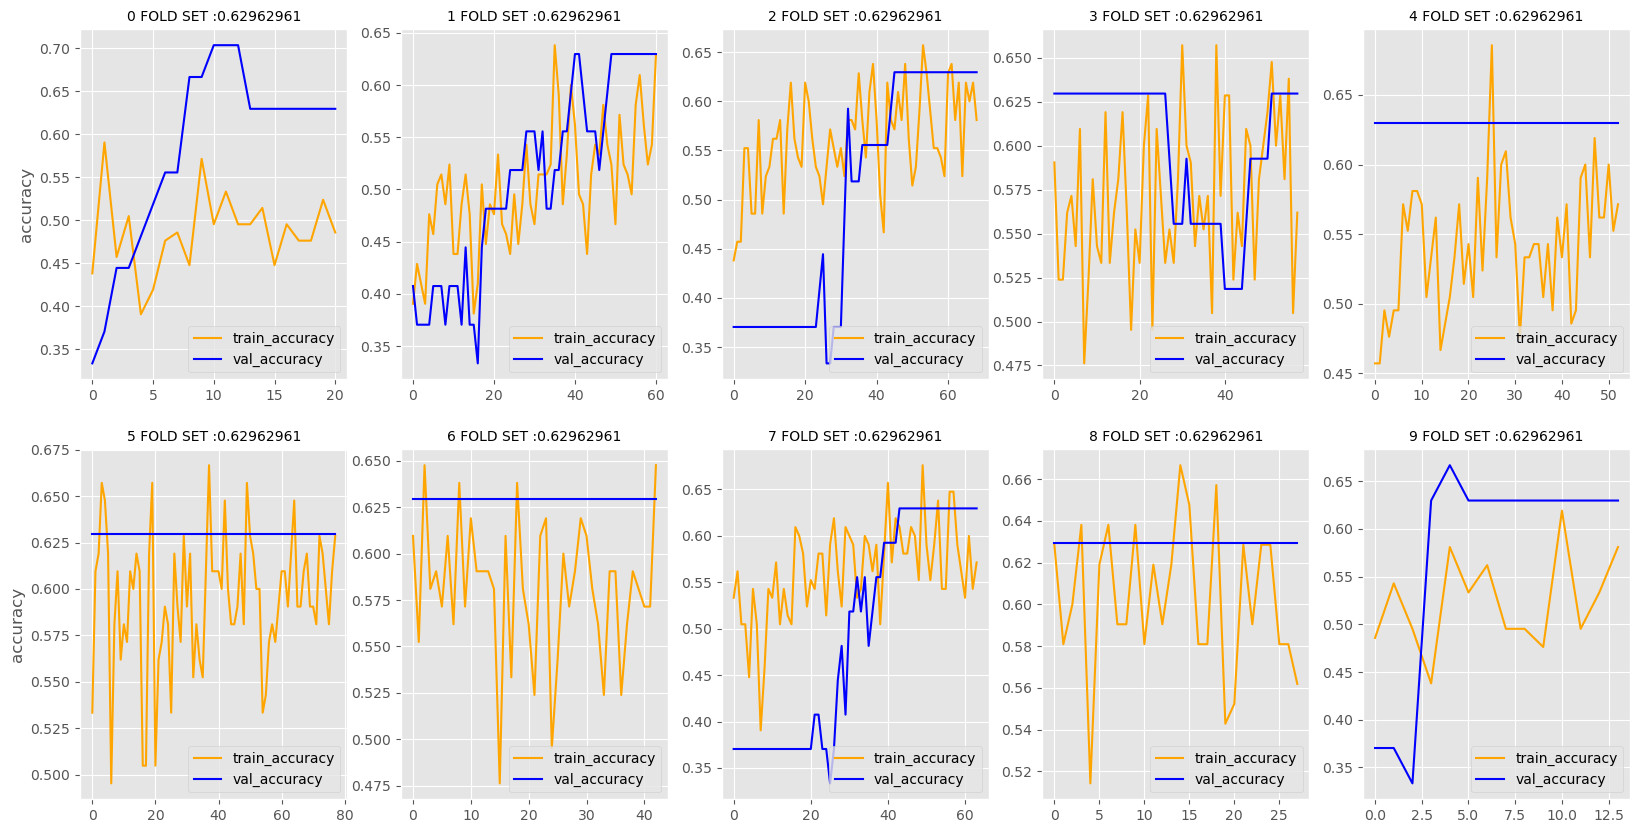

In [94]:
params = {'DROPOUT_RATE':0.4,
        'START_NODE':32,
        'HIDDEN_NODE':16,
        'LAYERS':5}

optimizers = {'loss':'BinaryCrossentropy',
        'optimizer':'adam',
        'metrics':'accuracy'}

REPEATE = 10

fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (20,10))
ax = ax.flatten()

for num in range(REPEATE):
        x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42 + num,
                                                                stratify = Y)
        
        model = DNN(**params)
        model.compile(**optimizers)
        
        history = model.fit(x_train,y_train,
                        validation_data = (x_test,y_test),
                        epochs = 9999,
                        callbacks = [early_stopping],
                        verbose = 0)
        ax[num].plot(history.history['accuracy'], label = 'train_accuracy', color = 'orange')
        ax[num].plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'blue')  
        
        ax[0].set_ylabel('accuracy')
        ax[5].set_ylabel('accuracy')
        ax[num].legend(loc = 'lower right')
        score = round(model.evaluate(x_test,y_test,verbose = 0)[-1],8)
        ax[num].set_title(f'{num} FOLD SET :{score}',fontsize = 10)
        